In [1]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from pymoo.factory import get_performance_indicator
from pymoo.util.nds.non_dominated_sorting import find_non_dominated

import numpy as np

import re

import torch

import lib.benchmarks.nasbench301.nasbench301 as nb
from lib.benchmarks.nasbench101.nasbench import api
from nats_bench import create

import os
from os.path import expanduser


In [2]:
load_pf = lambda x : np.load(x)
apis = {
    101: api.NASBench(os.path.join(expanduser('~'), '.torch/nasbench_only108.tfrecord')),
    201: create(None, 'tss', fast_mode=True, verbose=False),
    301: {
        #'xgb': nb.load_ensemble(os.path.join(expanduser('~'), '.torch/nb_models/xgb_v1.0')),
        #'gnn': nb.load_ensemble(os.path.join(expanduser('~'), '.torch/nb_models/gnn_gin_v1.0'))
    }
}
benchmarks = {
    101: torch.load('data/bench101_info.pth.tar'),
    201: torch.load('data/[cifar10-tss-200].pth.tar')['obj']
}

Loading dataset from file... This may take a few minutes...
Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
Loaded dataset in 46 seconds
[2021-07-12 18:30:58] Try to use the default NATS-Bench (topology) path from fast_mode=True and path=None.


In [3]:
INPUT = 'input'
OUTPUT = 'output'
CONV3X3 = 'conv3x3-bn-relu'
CONV1X1 = 'conv1x1-bn-relu'
MAXPOOL3X3 = 'maxpool3x3'
NUM_VERTICES = 7
ALLOWED_OPS = [CONV3X3, CONV1X1, MAXPOOL3X3]
EDGE_SPOT = NUM_VERTICES * (NUM_VERTICES - 1) // 2
OP_SPOTS = NUM_VERTICES - 2
def bench101_decoder(x):
    dag, ops = np.split(x, [EDGE_SPOT])
    matrix = \
        np.zeros((NUM_VERTICES, NUM_VERTICES)).astype(np.int)
    iu = np.triu_indices(NUM_VERTICES, k=1)
    matrix[iu] = dag
    ops = np.array(ALLOWED_OPS)[ops].tolist()

    ops = [INPUT] + ops + [OUTPUT]

    return matrix, ops

import lib.models.cell_operations as OPS
nodes = [0, 0, 1, 0, 1, 2]
primitives = np.array(OPS.NAS_BENCH_201)
def bench201_decoder(x):
    ops = primitives[x]
    strings = ['|']

    for i, op in enumerate(ops):
        strings.append(op+'~{}|'.format(nodes[i]))
        if i < len(nodes) - 1 \
            and nodes[i+1] == 0:
            strings.append('+|')
    return ''.join(strings)

from lib.darts.encoding import decode, convert, Genotype
def bench301_decoder(x):
    genotype = decode(convert(x))
    normal = genotype.normal; reduce = genotype.reduce
    normal_concat = reduce_concat = list(range(2, 6))
    genotype = Genotype(
        normal=normal,
        normal_concat=normal_concat,
        reduce=reduce,
        reduce_concat=reduce_concat
    )
    return genotype


In [4]:
def bench101_query(genotype, **kwargs):
    matrix, ops = genotype
    spec = api.ModelSpec(matrix, ops)
    key = apis[101]._hash_spec(spec)
    flops = benchmarks[101][key]['flops']
    scores = \
        benchmarks[101][key]['computed_stat'][108]
    test_acc = \
        np.mean([scores[i]['final_test_accuracy'] for i in range(3)])
    test_err = (1 - test_acc) * 100
    return [flops, test_err]

def bench201_query(genotype, **kwargs):
    idx = apis[201].query_index_by_arch(genotype)
    benchmark = benchmarks[201]
    flops = benchmark[idx][0]['flops']
    test_err = \
        100 - benchmark[idx][1]['test-accuracy']
    return [flops, test_err]

INIT_CHANNELS = 32
LAYERS = 8
AUXILIARY = True
from utils.neural_net.flops_benchmark import get_model_infos
from lib.darts.cnn.model import NetworkCIFAR
def bench301_query(genotype, surrogate_models=['xgb']):
    network = NetworkCIFAR(C=INIT_CHANNELS,
                           num_classes=10,
                           layers=LAYERS,
                           auxiliary=AUXILIARY,
                           genotype=genotype).cuda()
    network.drop_path_prob = -1
    flops, _ = get_model_infos(network, [1, 3, 32, 32])
    test_acc = np.mean([apis[301][key].predict(genotype, representation='genotype', with_noise=False)] for key in surrogate_models)
    test_err = 100 - test_acc
    return [flops, test_err]

In [5]:
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
def convert_2_obj_space(checkpoint_path,
                        decoder,
                        func,
                        metric,
                        return_non_dominated=True,
                        convert_obj=True,
                        **kwargs):
    max_r = 0
    n_evals, F, cv = [], [], []
    checkpoints = sorted(os.listdir(checkpoint_path), 
                         key=lambda x: int(re.search(r'-(\d+)', x).group(1)))
    best_arch = None; best_err = 100
    for i, filename in enumerate(checkpoints):
        checkpoint = torch.load(os.path.join(checkpoint_path, filename))
        obj = checkpoint['obj']
        n_evals += [obj.evaluator.n_eval]
        opt = obj.opt
        feas = np.where(opt.get('feasible'))[0]
        X = checkpoint['elitist_archive'].archive['X']
        _F = checkpoint['elitist_archive'].archive['F']
        max_r = max(max_r, len(X))
        __F = []
        if convert_obj:
            for x in X:
                genotype = decoder(x)
                f = func(genotype)
                err = f[1]
                if err < best_err:
                    best_err = err
                    best_arch = genotype
                __F += [f]
            __F = np.array(__F)
            if return_non_dominated:
                I = NonDominatedSorting().do(__F, only_non_dominated_front=True)
                F += [__F[I]]
            else:
                F += [__F]
        else:
            F += [_F]
    if convert_obj:
        score = [metric.calc(f) for f in F]
    else:
        score = None
    print('max_archive_size: {}'.format(max_r))
    print('Best test error: {}'.format(best_err))
    print('Best arch: {}'.format(best_arch))
    return n_evals, score, F

In [15]:
pf = load_pf('data/bench_pf/[cifar10-tss][FLOPS-TEST_ERR]-200EP.npy')

In [16]:
indicator_name = 'igd'
kwargs = {}
metric = get_performance_indicator(indicator_name, pf=pf, normalize=True, **kwargs)

In [8]:
def load_runs(f_dir, name, save=False, **kwargs):
    data = []
    for run in sorted(os.listdir(f_dir)):
        res = convert_2_obj_space(os.path.join(f_dir, run, 'checkpoints'), **kwargs)
        data += [res]
    if save:
        torch.save(data, 'data/{}.pth.tar'.format(name))
    return data

In [9]:
def get_runtime(f_dir, **kwargs):
    runtimes = []
    for run in sorted(os.listdir(f_dir)):
        run_dir = os.path.join(f_dir, run, 'checkpoints')
        gens = sorted(os.listdir(run_dir), key=lambda x: int(re.search(r'-(\d+)', x).group(1)))
        last_gen = gens[-1]
        time = list(torch.load(os.path.join(run_dir, last_gen))['score_dict']['runtimes'].values())
        avg_times = [sum(t) for t in time]
        runtimes += [avg_times]

    runtimes = np.array(runtimes)
    return runtimes

def get_runtime_from_log(path, **kwargs):
    logs_dir = os.path.join(path, 'logs')
    times = []
    for file in os.listdir(logs_dir):
        if 'debug' in file:
            with open(os.path.join(logs_dir, file), 'r+') as f:
                gens = \
                    re.findall(
                        "- PopLogger - : \{'current_gen': (\d+), 'n_evals': \d+, 'time': (\d+.\d+)}",                             f.read()
                    )
            gens = [(int(gen), float(time)) for i, (gen, time) in enumerate(gens) if i < 100]
            times += [*gens]
    times = sorted(times, key=lambda x: x[0])
    # assert(len(times) == 60)
    return [time for _, time in times]   

def get_log_runtimes_from_runs(path):
    runtimes = []
    for run in sorted(os.listdir(path)):
        runtimes += [get_runtime_from_log(os.path.join(path, run))]
    runtimes = np.array(runtimes)
    # assert(runtimes.shape == (29, 60))
    return runtimes

In [17]:
# baseline = load_runs(
#     f_dir='experiments/101-FLOPS-NTK-LR-100-6',
#     name='baseline101',
#     save=False,
#     decoder=bench101_decoder,
#     func=bench101_query,
#     metric=metric,
#     return_non_dominated=False,
#     convert_obj=True,
# )
baseline = torch.load('data/baseline201.pth.tar')
igd_baseline = np.array([run[1] for run in baseline])

runtimes = get_runtime('experiments/tss-flops-valid').mean(axis=0)
T = runtimes.copy()
for i, time in enumerate(runtimes):
    if i == 0:
        continue
    runtimes[i] += T[:i].sum()
runtimes /= 3600

# print(runtimes.shape)
# print(igd_baseline[:, :len(runtimes)].shape)

n_evals = baseline[0][0]
# data = [(n_evals, igd_baseline[:, :len(runtimes)], runtimes, 'FLOPs - error rate')]
data = [(n_evals, igd_baseline, None, 'FLOPs - error rate')]
# data = [(n_evals, igd_baseline, None, 'flops ori model')]

In [18]:
# gf = load_runs(
#     f_dir='experiments/101-FLOPS-NTK-LR',
#     name='gf101',
#     save=False,
#     decoder=bench101_decoder,
#     func=bench101_query,
#     metric=metric,
#     return_non_dominated=False,
#     convert_obj=True,
# )
gf = torch.load('data/gf201.pth.tar')
igd_gf = np.array([run[1] for run in gf])
runtimes = get_log_runtimes_from_runs('experiments/TSS-FLOPS-NTK-LR').mean(axis=0)
# # print(runtimes.shape)
T = runtimes.copy()
for i, time in enumerate(runtimes):
    if i == 0:
        continue
    runtimes[i] += T[:i].sum()
runtimes /= 3600
n_evals = gf[0][0]
# # assert(len(igd_gf201) == len(runtimes))
print(runtimes.shape)
print(igd_gf.shape)
# data += [(n_evals, igd_gf[:, :len(runtimes)], runtimes, r'FLOPs - $\kappa_{\mathcal{N}}$ - $R_\mathcal{N}$')]
data += [(n_evals, igd_gf, runtimes, r'FLOPs - $\kappa_{\mathcal{N}}$ - $R_\mathcal{N}$')]
# data += [(n_evals, igd_gf[:, :len(runtimes)], runtimes, r'flops 16 init channels')]


(60,)
(29, 60)


In [12]:
def performance_indicator_show(x, 
                               metric, 
                               title,
                               log_scale=True,
                               save_fig=False,
                               figname=None):
    linestyles = ['--', '-.']
    colors = ['blue', 'red']
    for i, (n_evals, score, _, label) in enumerate(x):
        plt.plot(n_evals, score.mean(axis=0), linestyles[i], color=colors[i], markersize=4, linewidth=2, label=label)
        plt.fill_between(
            n_evals, 
            score.mean(axis=0)-score.std(axis=0), 
            score.mean(axis=0)+score.std(axis=0), 
            alpha=.2,
            color=colors[i]
        )
    if log_scale:
        plt.xscale('log')
    plt.xlabel('Network evaluations', fontsize=15)
    # plt.figtext(0.55, -0.02, 'Function evaluations', ha='center', va='center', fontsize=15)
    plt.ylabel(metric, fontsize=15)
    plt.legend(loc='best')
    plt.grid(True, linestyle='--')
    plt.title(title)
    if save_fig:
        plt.savefig('assets/{}'.format(figname), bbox_inches='tight', pad_inches=0.0)
    plt.show()

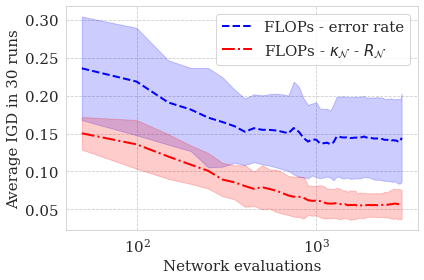

In [19]:
plt.rc('legend', fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rcParams["font.family"] = "serif"

performance_indicator_show(
    data, 
    'Average IGD in 30 runs', 
    '',
    save_fig=True, 
    figname='bench201-all.pdf'
)

In [44]:
from matplotlib.ticker import ScalarFormatter
def runtime_show(x, 
                 metric, 
                 title, 
                 log_scale=True,
                 save_fig=False,
                 figname=None):
    ends = []
    linestyles = ['--', '-.']
    colors = ['blue', 'red']
    gpus = ['(GTX 1080Ti)', '(GTX 1070)']
    fig, ax = plt.subplots()
    for i, (_, score, runtimes, label) in enumerate(x):
        ax.plot(runtimes, score.mean(axis=0), linestyles[i], color=colors[i], markersize=4, linewidth=2, label=label + ' ' + gpus[i])
        ax.fill_between(
            runtimes,
            score.mean(axis=0)-score.std(axis=0),
            score.mean(axis=0)+score.std(axis=0),
            alpha=.2,
            color=colors[i]
        )
        ends += [runtimes[0], runtimes[-1]]
    if log_scale:
        ax.set_xscale('log')
    ax.set_xlabel('GPU Hours')
    ax.set_ylabel(metric)
    plt.legend(loc='best')
    ax.set_xticks(ends)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    plt.grid(True, linestyle='--')
    # plt.xticks(rotation=90)
    plt.title(title)
    if save_fig:
        plt.savefig('assets/{}'.format(figname), bbox_inches='tight', pad_inches=0.0)
    plt.show()

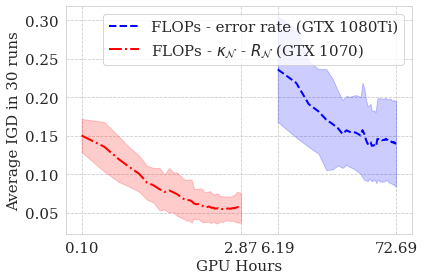

In [46]:
runtime_show(
    data, 
    'Average IGD in 30 runs', 
    '', 
    log_scale=True,
    save_fig=True,
    figname='bench201-all-time.pdf'
)

In [6]:
def pareto_front_show(X):
    for f, label, alpha in X:
        plt.scatter(f[:, 0], f[:, 1], label=label, alpha=alpha)
    plt.xlabel('FLOPS')
    plt.ylabel('Test Error (%)')
    plt.grid(True, linestyle='--')
    plt.legend(loc='best')
    plt.show()

In [47]:
BL_cifar100 = torch.load('data/baseline201_to_cifar100.pth.tar')
GF_cifar100 = torch.load('data/gf201_to_cifar100.pth.tar')
pf_cifar100 = np.load('data/bench_pf/[cifar100-tss][FLOPS-TEST_ERR]-200EP.npy')

BL_imagenet = torch.load('data/baseline201_to_imagenet.pth.tar')
GF_imagenet = torch.load('data/gf201_to_imagenet.pth.tar')
pf_imagenet = np.load('data/bench_pf/[ImageNet16-120-tss][FLOPS-TEST_ERR]-200EP.npy')

In [48]:
plt.rc('legend', fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rcParams["font.family"] = "serif"

In [11]:
plt.rcParams["font.family"] = "serif"

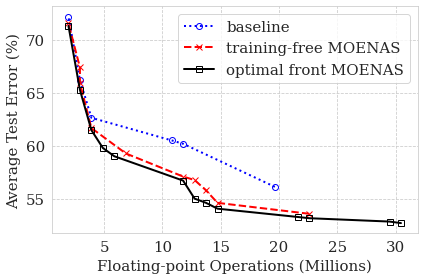

In [54]:
r = 22
baseline_cifar100 = np.array(BL_cifar100[r][2][-1])
baseline_imagenet = np.array(BL_imagenet[r][2][-1])
gf_cifar100 = np.array(GF_cifar100[r][2][-1])
gf_imagenet = np.array(GF_imagenet[r][2][-1])
pf_cifar100 = pf_cifar100[np.argsort(pf_cifar100[:, 1])]
pf_imagenet = pf_imagenet[np.argsort(pf_imagenet[:, 1])]

I_cifar100 = find_non_dominated(baseline_cifar100, baseline_cifar100)
baseline_cifar100 = baseline_cifar100[I_cifar100]
baseline_cifar100 = baseline_cifar100[np.argsort(baseline_cifar100[:, 1])]
I_imagenet = find_non_dominated(baseline_imagenet, baseline_imagenet)
baseline_imagenet = baseline_imagenet[I_imagenet]
baseline_imagenet = baseline_imagenet[np.argsort(baseline_imagenet[:, 1])]

J_cifar100 = find_non_dominated(gf_cifar100, gf_cifar100)
gf_cifar100 = gf_cifar100[J_cifar100]
gf_cifar100 = gf_cifar100[np.argsort(gf_cifar100[:, 1])]
J_imagenet = find_non_dominated(gf_imagenet, gf_imagenet)
gf_imagenet = gf_imagenet[J_imagenet]
gf_imagenet = gf_imagenet[np.argsort(gf_imagenet[:, 1])]

fig, axes = plt.subplots(ncols=1, tight_layout=True)

# axes.plot(baseline_cifar100[:, 0], baseline_cifar100[:, 1], ':o', label='baseline MOENAS', color='blue', linewidth=2, mfc='none')
# axes.plot(gf_cifar100[:, 0], gf_cifar100[:, 1], '--x', label='training-free MOENAS', color='red', linewidth=2, mfc='none')
# axes.plot(pf_cifar100[:, 0], pf_cifar100[:, 1], '-s', label='optimal front', color='black', linewidth=2, mfc='none')
# axes.grid(linestyle='--')
# axes.legend(loc='best')

axes.plot(baseline_imagenet[:, 0], baseline_imagenet[:, 1], ':o', label='baseline MOENAS', color='blue', linewidth=2, mfc='none')
axes.plot(gf_imagenet[:, 0], gf_imagenet[:, 1], '--x', label='training-free MOENAS', color='red', linewidth=2, mfc='none')
axes.plot(pf_imagenet[:, 0], pf_imagenet[:, 1], '-s', label='optimal front', color='black', linewidth=2, mfc='none')
axes.grid(linestyle='--')
axes.legend(loc='best')

# plt.figtext(0.55, 0.01, 'Floating-point Operations (Millions)', ha='center', va='center')
plt.ylabel('Average Test Error (%)')
plt.xlabel('Floating-point Operations (Millions)')
plt.savefig('assets/{}'.format('transfer-front-imagenet.pdf'), bbox_inches='tight', pad_inches=0.0)
plt.show()


Random number: 22


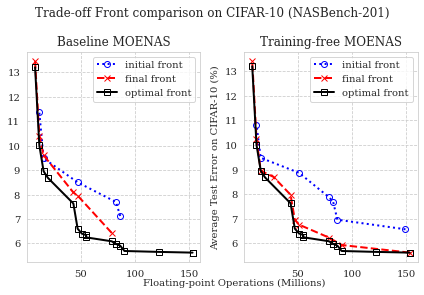

In [82]:
# F_baseline = [np.array(res[2][-1]) for res in baseline]
# F_gf = [np.array(res[2][-1]) for res in gf]

r = np.random.choice(np.arange(30))
r = 22
print('Random number: {}'.format(r))
# baseline_init = np.array(baseline[r][2][0])
# gf_init = np.array(gf[r][2][0])
F_baseline = np.array(baseline[r][2][-1])
F_gf = np.array(gf[r][2][-1])

F_baseline_all = np.row_stack(F_baseline)
F_gf_all = np.row_stack(F_gf)

baseline_init = np.row_stack(baseline_init)
gf_init = np.row_stack(gf_init)

I_init = find_non_dominated(baseline_init, baseline_init)
J_init = find_non_dominated(gf_init, gf_init)

I = find_non_dominated(F_baseline_all, F_baseline_all)
neg_I = list(set(range(len(F_baseline_all))) - set(I))

J = find_non_dominated(F_gf_all, F_gf_all)
neg_J = list(set(range(len(F_gf_all))) - set(J))

pf = pf[np.argsort(pf[:, 1])]
# print(F_gf_all.shape)
# print(F_baseline_all.shape)

# print(len(F_baseline))
# print(len(F_gf))

F_baseline_I = F_baseline_all[I]
F_baseline_I = F_baseline_I[np.argsort(F_baseline_I[:, 1])]

F_gf_I = F_gf_all[J]
F_gf_I = F_gf_I[np.argsort(F_gf_I[:, 1])]

baseline_init_I = baseline_init[I_init]
baseline_init_I = baseline_init_I[np.argsort(baseline_init_I[:, 1])]

gf_init_I = gf_init[J_init]
gf_init_I = gf_init_I[np.argsort(gf_init_I[:, 1])]

fig, axes = plt.subplots(ncols=2, tight_layout=True, sharex=True)



axes[0].plot(baseline_init_I[:, 0], baseline_init_I[:, 1], ':o', label='initial front', mfc='none', linewidth=2, color='blue')
axes[0].plot(F_baseline_I[:, 0], F_baseline_I[:, 1], '--x', label='final front', mfc='none', linewidth=2, color='red')
axes[0].plot(pf[:, 0], pf[:, 1], '-s', label='optimal front', color='black', mfc='none', linewidth=2)
axes[0].set_title('Baseline MOENAS')
axes[0].grid(linestyle='--')
# plt.plot(F_baseline_all[:, 0][neg_I], F_baseline_all[:, 1][neg_I], '.', mfc='none', color='blue', alpha=.5)

axes[1].plot(gf_init_I[:, 0], gf_init_I[:, 1], ':o', label='initial front', mfc='none', linewidth=2, color='blue')
axes[1].plot(F_gf_I[:, 0], F_gf_I[:, 1], '--x', label='final front', mfc='none', linewidth=2, color='red')
axes[1].plot(pf[:, 0], pf[:, 1], '-s', label='optimal front', color='black', mfc='none', linewidth=2)
axes[1].set_title('Training-free MOENAS')
axes[1].grid(linestyle='--')
# plt.plot(F_gf_all[:, 0][neg_J], F_gf_all[:, 1][neg_J], 'x', mfc='none', color='red', alpha=.5)

axes[0].legend(loc='best')
axes[1].legend(loc='best')

plt.figtext(0.55, 0.02, 'Floating-point Operations (Millions)', ha='center', va='center')
plt.ylabel('Average Test Error on CIFAR-10 (%)')
plt.suptitle('Trade-off Front comparison on CIFAR-10 (NASBench-201)')
plt.savefig('assets/201-front.pdf')
plt.show()

In [7]:
bl = load_runs(
    f_dir='experiments/TSS-FLOPS-VALID',
    name='baseline201_2obj',
    save=True,
    decoder=bench201_decoder,
    func=bench201_query,
    metric=None,
    return_non_dominated=False,
    convert_obj=False,
)

max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 7
Best test error: 100
Best arch: None
max_archive_size: 7
Best test error: 100
Best arch: None
max_archive_size: 6
Best test error: 100
Best arch: None
max_archive_size: 8
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 8
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 7
Best test error: 100
Best arch: None
max_archive_size: 7
Best test error: 100
Best arch: None
max_archive_size: 10
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 8
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 9
Best test error: 100
Best arch: None
max_archive_size: 8
Best test error: 100
Best arch: None
max_archive_size: 5
Best test 

Random number: 24


<ipython-input-16-62c4d3fc575f>:11: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
/home/tudo/miniconda3/envs/cuda/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


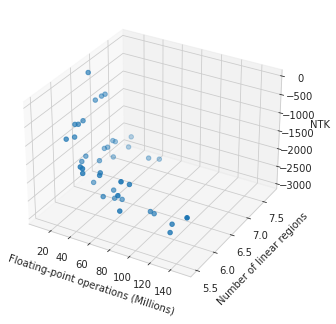

In [16]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D


r = np.random.choice(np.arange(29))
print('Random number: {}'.format(r))
gf_init = np.array(gf[r][2][0])
F_gf = np.array(gf[r][2][-1])

fig = plt.figure()
ax = Axes3D(fig)
fig.add_axes(ax)

ax.scatter3D(F_gf[:, 0], F_gf[:, 1], F_gf[:, 2], marker="o", label="Global Optimum")
ax.set_xlabel('Floating-point operations (Millions)')
ax.set_ylabel('Number of linear regions')
ax.set_zlabel('NTK')
plt.show()